In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# :https://claude.ai/chat/d2308f5c-b8e1-49de-8e54-05d92dc8017b
# https://grok.com/c/29b64892-22ce-4423-b6c5-26e01ed4bef6
# https://chatgpt.com/c/68d13b9b-5790-832b-aad0-858310b6b5dd

In [26]:
# Loading the data
df = pd.read_csv('Cleaned_DS.csv')
df.head()

,Temperature,Humidity,CO2,HumidityRatio,Occupancy,Hour,Minute,Day
0,23.70,26.27,749.20,0.00476,1,14,19,2
1,23.72,26.29,760.40,0.00477,1,14,19,2
2,23.73,26.23,769.67,0.00477,1,14,21,2
3,23.72,26.12,774.75,0.00474,1,14,22,2
4,23.75,26.20,779.00,0.00477,1,14,23,2


In [27]:
df.shape

(20506, 8)

In [28]:
# Making label and features
X = df.drop('Occupancy', axis=1).values
y = df['Occupancy'].values


# Calculating class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict



n = len(X)
train_size=0.7
val_size=0.15

train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))
X_train = X[:train_end]
y_train = y[:train_end]
    
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
    
X_test = X[val_end:]
y_test = y[val_end:]


scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)


Shape of training data: (14354, 7) (14354,)
Shape of validation data: (3076, 7) (3076,)
Shape of test data: (3076, 7) (3076,)


In [29]:
# Creating sequences:
def create_windows(X, y, window_size=60, stride=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size + 1, stride):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = create_windows(X_train, y_train)
X_val, y_val = create_windows(X_val, y_val)
X_test, y_test = create_windows(X_test, y_test)

print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)

Training sequences shape: (14295, 60, 7)
Training class shape: (14295,)


In [30]:
num_0 = (y_train == 0).sum()
num_1 = (y_train == 1).sum()
total = len(y_train)
weight_for_0 = total / (2 * num_0)
weight_for_1 = total / (2 * num_1)
class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)

Class weights: {0: 0.6631564297643348, 1: 2.032271822576059}


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same',
           input_shape=(60, X_train.shape[2])),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 60, 64)         │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 60, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        30,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,649 (154.88 KB)

 Trainable params: 39,457 (154.13 KB)

 Non-trainable params: 192 (768.00 B)

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1)

In [34]:
history = model.fit(X_train, y_train, 
    epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stop, reduce_lr],
    validation_data=(X_val, y_val),verbose=2)

Epoch 1/20
224/224 - 2s - 11ms/step - accuracy: 0.8784 - loss: 0.2551 - precision: 0.6839 - val_accuracy: 0.9072 - val_loss: 0.2591 - val_precision: 0.6942 - learning_rate: 0.0010
Epoch 2/20
224/224 - 1s - 4ms/step - accuracy: 0.9296 - loss: 0.1594 - precision: 0.7945 - val_accuracy: 0.8634 - val_loss: 0.2255 - val_precision: 0.9394 - learning_rate: 0.0010
Epoch 3/20
224/224 - 1s - 4ms/step - accuracy: 0.9447 - loss: 0.1232 - precision: 0.8320 - val_accuracy: 0.8124 - val_loss: 0.3392 - val_precision: 0.5096 - learning_rate: 0.0010
Epoch 4/20
224/224 - 1s - 4ms/step - accuracy: 0.9501 - loss: 0.1141 - precision: 0.8463 - val_accuracy: 0.9592 - val_loss: 0.1187 - val_precision: 0.8556 - learning_rate: 0.0010
Epoch 5/20
224/224 - 1s - 4ms/step - accuracy: 0.9568 - loss: 0.0993 - precision: 0.8663 - val_accuracy: 0.9287 - val_loss: 0.1705 - val_precision: 0.8467 - learning_rate: 0.0010
Epoch 6/20
224/224 - 1s - 4ms/step - accuracy: 0.9608 - loss: 0.0918 - precision: 0.8753 - val_accuracy:

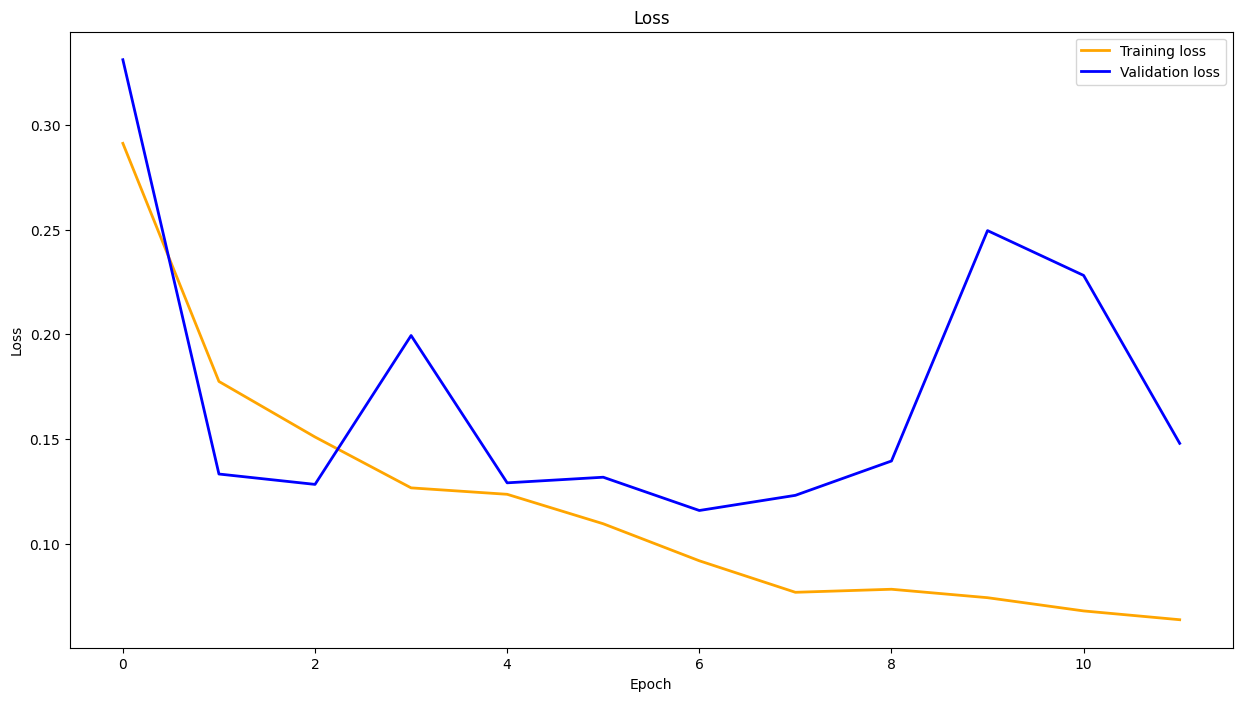

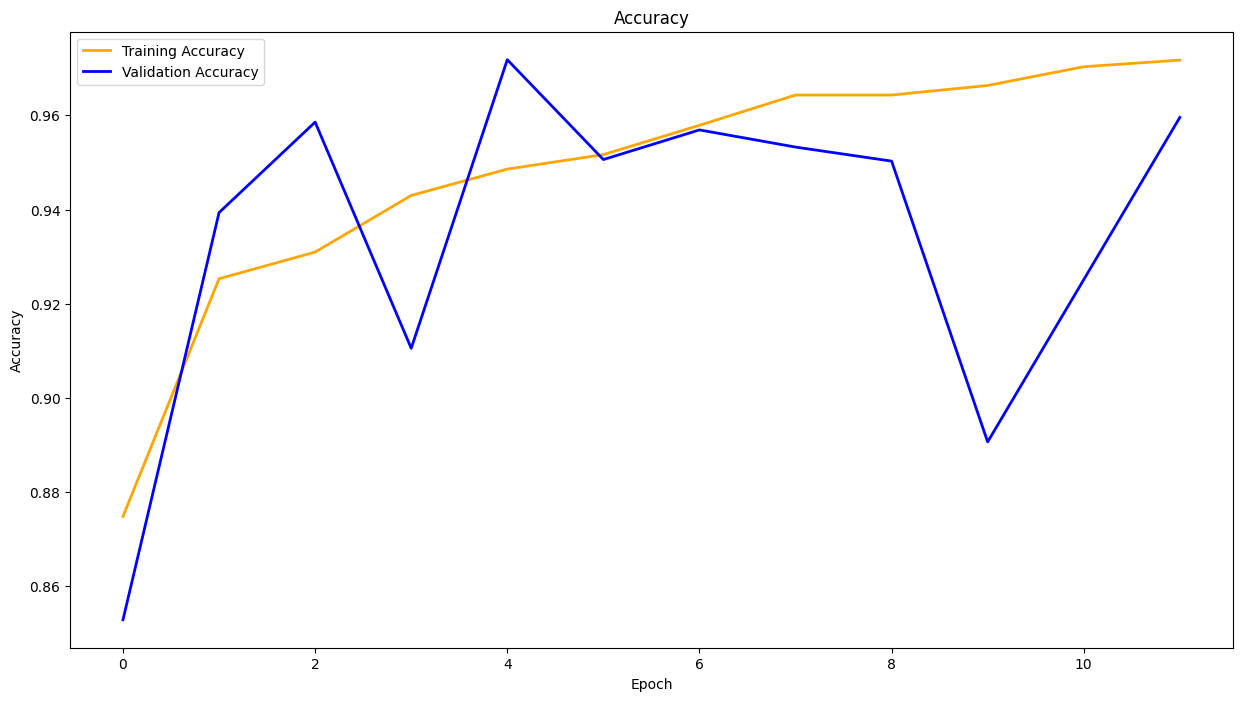

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training Accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


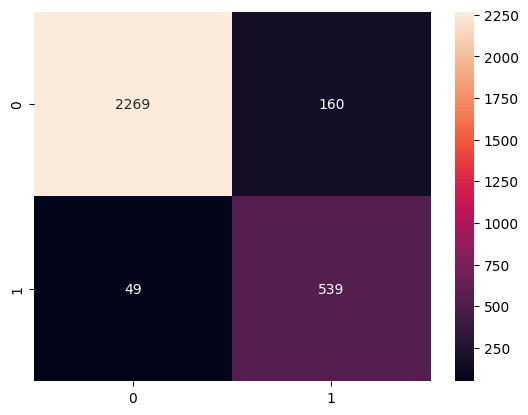

In [12]:
# Predict on test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [13]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2429
           1       0.77      0.92      0.84       588

    accuracy                           0.93      3017
   macro avg       0.87      0.93      0.90      3017
weighted avg       0.94      0.93      0.93      3017

